In [138]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from math import log
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [30]:
def test_statistique():
    data = impute_data()  
    print(" ")
    for column in data.columns[1:]:
        # print des boxplot pour chaque column(variable) pour identifier visuallement des points extremes
        print( column + "'s boxplot")
        f,ax=plt.subplots(figsize=(10,8))
        sns.boxplot(data=data['STA'],ax=ax)
        plt.show()
        print("==========================================================================================================")
        print(" ")

Show the first 5 lines de data
   Default      WCTA      RETA   EBIT_TA      METL       STA
0        1  0.500799  0.306846  0.043373  0.956271  0.334774
1        1  0.547780  0.322214  0.051843  1.064545  0.334591
2        1  0.451001  0.225150  0.026813  0.804096  0.245585
3        1  0.306887  0.191936  0.030058  0.387010  0.253438
4        1  0.447246  0.217368  0.032458  0.791639  0.275531
 
WCTA's boxplot
 


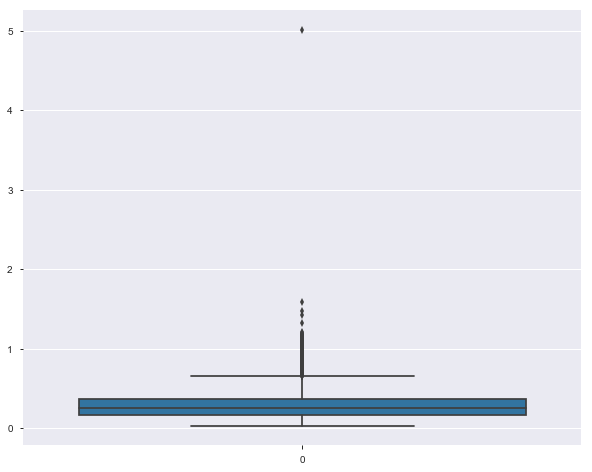

RETA's boxplot
 


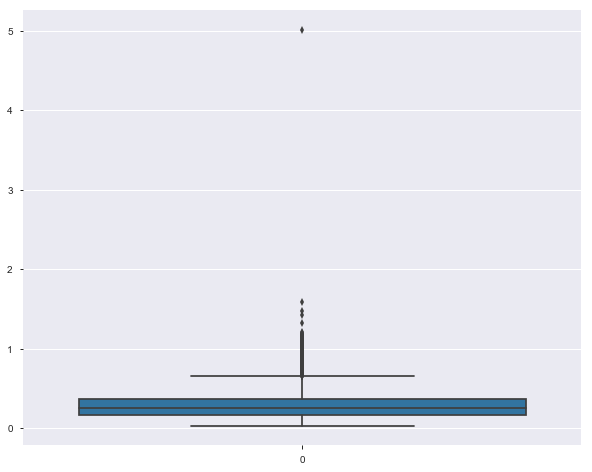

EBIT_TA's boxplot
 


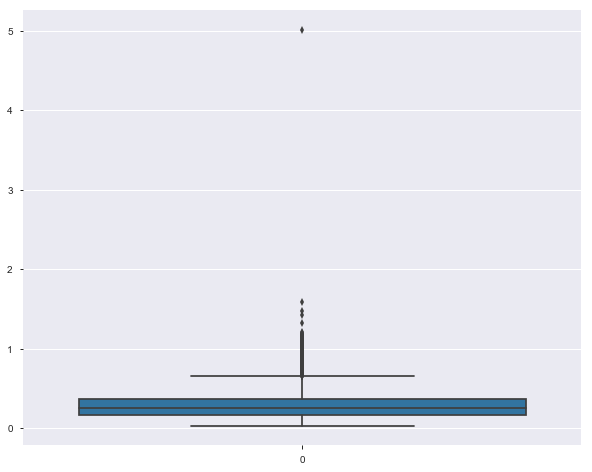

METL's boxplot
 


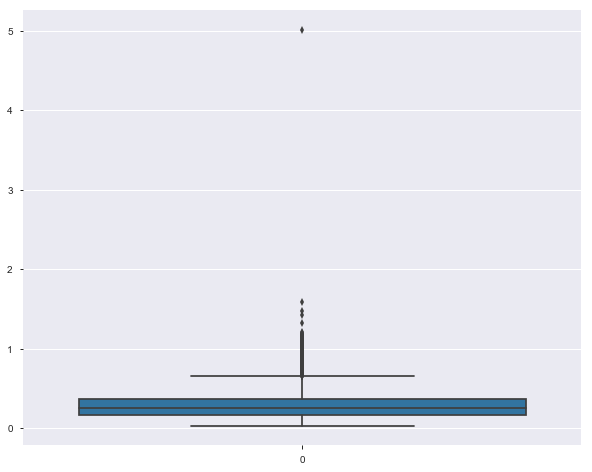

STA's boxplot
 


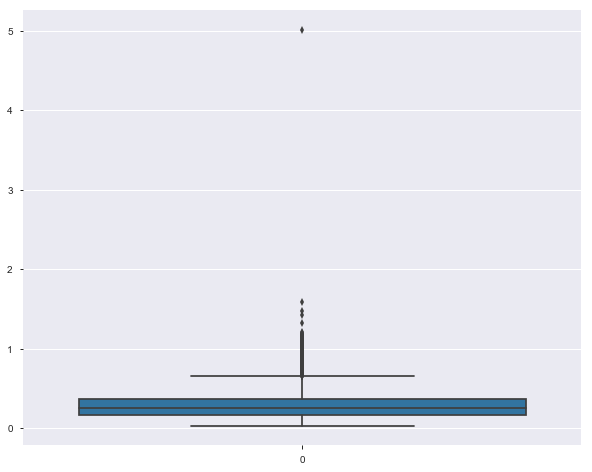

In [29]:
test_statistique()
pandas_profiling.ProfileReport(pd.read_excel("C:\\Users\\57621\\Desktop\\IMSD\\scoring\\projet\\data_scoring.xlsx").iloc[:,2:])

In [139]:
def impute_data():
    #impute data from local
    data = pd.read_excel("C:\\Users\\57621\\Desktop\\IMSD\\scoring\\projet\\data_scoring.xlsx")
    data = data.iloc[:,2:]
    return data

def preprocessing_data(data,columns_list):
    data_x = pd.DataFrame(data,columns=columns_list)
    scaler = StandardScaler()
    # centrer et réduire des données
    x = scaler.fit_transform(data_x)
    y = np.array(data.iloc[:,0],dtype=int)
    return x,y

def discretisation_data(x,columns_list):
    x = pd.DataFrame(x,columns=columns_list)
    # Utiliser la méthode KMeans pour rassembler des individues en 3 clusters 
    km = KMeans(n_clusters=3,n_jobs=4)
    for column in columns_list:
        km.fit(np.array(data[column]).reshape(-1,1))
        c = pd.DataFrame(km.cluster_centers_).sort_values(0)
        w = []
        for i in [0,1]:
            # Trouver des points de splits en utilisant la moyenne entre deux centre de cluster
            mean = (c.iloc[i+1]+c.iloc[i])/2
            w.append(mean)
        
        # Spliter la column en 3 classes et leur attribuer une valuer différente
        if column == "WCTA" or column == "STA":
            x[column].loc[x[column] <= list(w[0])[0]] = 0
            x[column].loc[x[column] > list(w[1])[0]] = 2
            x[column].loc[(x[column] <= list(w[1])[0])&(x[column] > list(w[0])[0])] = 1
        elif column == "RETA" or column == "EBIT_TA":
            x[column].loc[x[column] > list(w[1])[0]] = 1
            x[column].loc[(x[column] <= list(w[1])[0])&(x[column] > list(w[0])[0])] = 0
            x[column].loc[x[column] <= list(w[0])[0]] = 2
        else:
            x[column].loc[x[column] <= list(w[0])[0]] = 0
            x[column].loc[x[column] > list(w[1])[0]] = 20
            x[column].loc[(x[column] <= list(w[1])[0])&(x[column] > list(w[0])[0])] = 10
    new_columns_list = []
    #renouvelle des noms de columns pour le nouueau data 
    for i in range(len(columns_list)):
        new_columns_list.append(columns_list[i] + "_0")
        new_columns_list.append(columns_list[i] + "_1")
        new_columns_list.append(columns_list[i] + "_2")
    
    # Utiliser la méthode de Onehot pour discréstiser la variable
    one = OneHotEncoder()
    new_x = pd.DataFrame(one.fit_transform(x).toarray(),columns=new_columns_list)
    
    return new_x


def split_data(x,y):
    # Split la data en datat_train et data_test
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=22)
    return x_train,x_test,y_train,y_test

def search_parameters(x_train,y_train):
    # Trouver des parametres du modèle les plus performantes en utilisant GridSearchCV
    k = int(sum(y_train==1)/sum(y_train==0))
    class_weight = []
    for i in range(k-5,k+5):
        class_weight.append({1:1,0:i})
    parameters = {'C':[0.01,0.1,1,5,10,100],'class_weight':class_weight}
    lg = LogisticRegression()
    lg_clf = GridSearchCV(lg,parameters,cv=5,n_jobs=3,verbose=5,scoring='roc_auc')
    lg_clf.fit(x_train,y_train)
    return lg_clf.best_params_

def train(columns_list,discre=False):
    
    for i in columns_list:
        if i not in ['Default', 'WCTA', 'RETA', 'EBIT_TA', 'METL', 'STA']:
            print("varaible inconnu")
            return 0
    data = impute_data()
    x,y = preprocessing_data(data,columns_list)
    # Décide si nous ferrons la dicrétisation de données ou pas 
    if discre:
        x = discretisation_data(x,columns_list)
    # Splite data en data_train et data_test
    x_train,x_test,y_train,y_test = split_data(x,y)
    best_param = search_parameters(x_train,y_train)
    # Créer nos modèle de Logistique
    lg = LogisticRegression(C=best_param["C"],class_weight=best_param["class_weight"],solver='lbfgs',max_iter=1000,random_state=22)
    lg.fit(x_train,y_train)
    return lg,x_train,x_test,y_train,y_test
    
def model_result(columns_list,discre=False):
    lg,x_train,x_test,y_train,y_test = train(columns_list,discre=discre)
    # Prédire la catégorie d'individus avec des données de test
    y_pred = lg.predict(x_test)
    y_pred_proba = lg.predict_proba(x_test)[:,1]
    print("Coefficient du modele")
    print(lg.coef_)
    print(" ")
    print("==================================================================")
    print("")
    print("AIC and BIC")
    w = lg.coef_
    sse = 0
    for i in range(len(x_train)):
        k = x_train[i].dot(w.T)
        sse += k*y_train[i]-log(np.exp(k)+1)
    aic = 2 * len(data.columns) - 2*sse
    bic = log(len(y_train)) * len(data.columns) - 2*sse
    print("aic: "+str(aic))
    print("bic: "+str(bic))
    print("==================================================================")
    print(" ")
    print("Classification Report")
    print(classification_report(y_test,y_pred))
    print(" ")
    print(" ==================================================================")

    confusion =confusion_matrix(y_test,y_pred)
    indices = range(len(confusion))
    plt.figure()
    plt.xticks(indices, [0,1])
    plt.yticks(indices, [0,1])
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.imshow(confusion.T, cmap=plt.cm.Blues)
    plt.ylabel('guess')
    plt.xlabel('fact')
    plt.title("Confusion Matrix")
    plt.colorbar()

    plt.figure()
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.title("ROC Courbre")
    plt.legend()

def grill_score(coef):
    s = 0.0
    d = []
    for i in range(len(coef)//3): 
        diff = max(coef[i*3:(i+1)*3]) - min(coef[i*3:(i+1)*3]) 
        s += diff
        d.append(diff)
    for i in range(len(coef)):
        tmp =  coef[i] - min(coef[(i//3)*3:(i//3+1)*3]) 
        table = round((tmp/s)*1000)
    return table



𝑦 = 𝑓(𝑊𝐶𝑇𝐴,𝑅𝐸𝑇𝐴)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    8.5s finished


Coefficient du modele
[[-0.09127847  1.58262843]]
 

AIC and BIC
aic: [4722.20341977]
bic: [4757.82766795]
 
Classification Report
             precision    recall  f1-score   support

          0       0.06      0.88      0.12        17
          1       1.00      0.82      0.90      1183

avg / total       0.98      0.82      0.89      1200

 


No handles with labels found to put in legend.


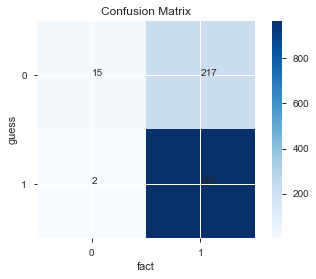

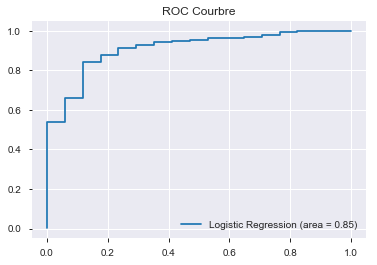

In [82]:
model_result(['WCTA','RETA'])

𝑦 = 𝑓 ( 𝑀𝐸𝑇𝐿, 𝐸𝐵𝐼𝑇𝑇𝐴)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.5s finished


Coefficient du modele
[[2.49786893 0.76325871]]
 

AIC and BIC
aic: [5898.84215796]
bic: [5934.46640614]
 
Classification Report
             precision    recall  f1-score   support

          0       0.04      0.65      0.07        17
          1       0.99      0.77      0.87      1183

avg / total       0.98      0.77      0.86      1200

 


No handles with labels found to put in legend.


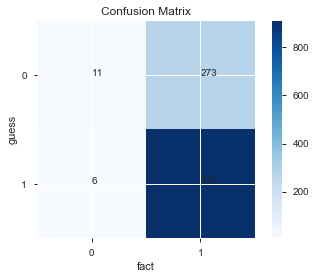

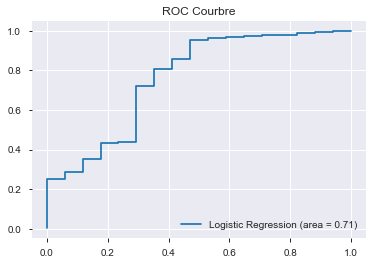

In [83]:
model_result(['METL','EBIT_TA'])

𝑦 = 𝑓 (𝑊𝐶𝑇𝐴, 𝑅𝐸𝑇𝐴, 𝐸𝐵𝐼𝑇𝑇𝐴, 𝑆𝑇𝐴)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=3)]: Done 227 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.3s finished


Coefficient du modele
[[-0.01011319  1.24602092  1.05644442 -0.61767734]]
 

AIC and BIC
aic: [5069.1698697]

No handles with labels found to put in legend.



bic: [5104.79411788]
 
Classification Report
             precision    recall  f1-score   support

          0       0.08      0.82      0.15        17
          1       1.00      0.87      0.93      1183

avg / total       0.98      0.87      0.92      1200

 


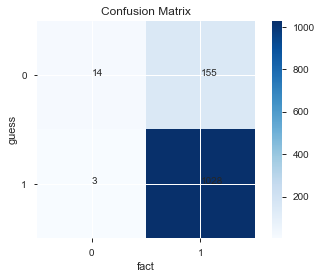

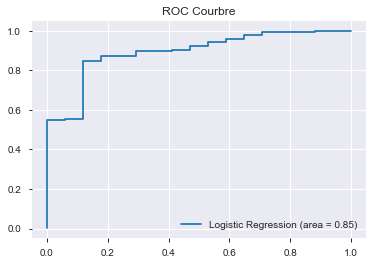

In [84]:
model_result(['WCTA','RETA','EBIT_TA','STA'])

𝑦 = 𝑓(𝑊𝐶𝑇𝐴,𝑅𝐸𝑇𝐴, 𝐸𝐵𝐼𝑇𝑇𝐴, 𝑀𝐸𝑇𝐿, 𝑆𝑇𝐴)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    6.2s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.4s finished


Coefficient du modele
[[-0.00995648  0.96519207  0.77508348  0.52177906 -0.48227504]]
 

AIC and BIC
aic: [4899.27592492]
bic: [4934.9001731]
 
Classification Report
             precision    recall  f1-score   support

          0       0.07      0.71      0.13        17
          1       1.00      0.87      0.93      1183

avg / total       0.98      0.87      0.92      1200

 


No handles with labels found to put in legend.


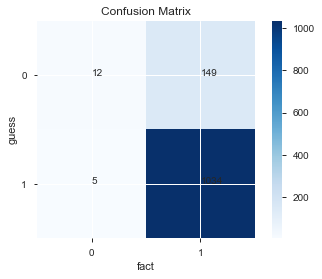

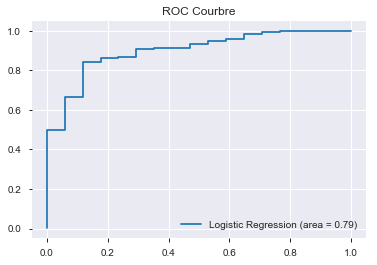

In [85]:
model_result(['WCTA','RETA','EBIT_TA','METL','STA'])